In [29]:
# 이 부분은 처음 한번만 실행하면 됌.
# 코드 수정 - "The reason is that the last Ubuntu update update supports chromium driver just via snap."
# 최근 우분투 업데이트에서 크롬 드라이버 설치를 snap을 이용해서만 하도록 바뀜
# 고로 snap 없이 설치하는 아래 우회 코드로 변경
# 출처 : https://colab.research.google.com/drive/1cbEvuZOhkouYLda3RqiwtbM-o9hxGLyC
# 출처2 : https://stackoverflow.com/questions/75155063/selenium-use-chrome-on-colab-got-unexpectedly-exited

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.XnJzWX0nSi/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.kGaX8oAwrE/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.LEwe9f3yJt/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

In [30]:
#필요한 것 import
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [31]:
def highlight_min_max(value):
    if value == df.min().min():
        return 'background-color: red'
    elif value == df.max().max():
        return 'background-color: blue'
    else:
        return ''

In [32]:
#input값 설정
user_input = input("기준금리와 CD금리, 그리고 예상하는 CD금리-기준금리를 입력하세요(ex : 3.5/3.75/0.15)" )
user_input = user_input.split("/")

기준금리와 CD금리, 그리고 예상하는 CD금리-기준금리를 입력하세요(ex : 3.5/3.75/0.15)3.5/3.75/0.25


In [33]:
#설정
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=options)

In [34]:
#url 지정
url = 'http://www.smbs.biz/Exchange/IRS.jsp'
driver.get(url)
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [35]:
# 소스 가져오기
table = soup.find('table', summary='기일물/1Y/2Y/3Y/4Y/5Y/7Y/10Y')

In [36]:
#가져오는 코드

irs_table = table.find_all('tbody')
data = []

for element in irs_table:
    selected_text = element.get_text().strip().split('\n\n')
    selected_text = [x.split('\n') for x in selected_text]
    # 빈 리스트인 경우 data에 추가하지 않음
    if selected_text != " ":
        data.extend(selected_text)

df = pd.DataFrame(data)

In [37]:
# 필요한 데이터만 가공

df.loc[0, [1, 2, 3, 4]] = df.iloc[0, [0, 1, 2, 3]].values
df = df.drop(columns=[0 ,1, 2, 3]).drop(index=df.index[5:])
df.index = ['0.50','0.75','1.00','1.50','2.00']
df.columns = ["Spot"]
df = df.astype(float)

In [38]:
#생성
df.loc['0.25'] = user_input[1]
df.loc['1.25'] = (df.loc['1.00'] + df.loc['1.50'])/2
df.loc['1.75'] = (df.loc['1.50'] + df.loc['2.00'])/2
df = df.sort_index()
df = df.astype(float)

In [39]:
df['DF'] = None
df['Zero']=None
df['Forward']=None
df['Reflection']=None

In [40]:
# DF 만들기
df.loc['0.25','DF'] = 1/(1+df.loc['0.25','Spot']/100*0.25) #맨 앞에거는 해야함
df.loc['0.50','DF'] = (1-df.loc['0.50','Spot']/100*df.loc['0.25','DF']*(0.5-0.25))/(1+df.loc['0.50','Spot']/100*(0.5-0.25))
df.loc['0.75','DF'] = (1-df.loc['0.75','Spot']/100*(df.loc['0.25','DF']+df.loc['0.50','DF'])*(0.5-0.25))/(1+df.loc['0.50','Spot']/100*(0.5-0.25))
df.loc['1.00','DF'] = (1-df.loc['1.00','Spot']/100*(df.loc['0.25','DF']+df.loc['0.50','DF']+df.loc['0.75','DF'])*(0.5-0.25))/(1t+df.loc['0.50','Spot']/100*(0.5-0.25))
df.loc['1.25','DF'] = (1-df.loc['1.25','Spot']/100*(df.loc['0.25','DF']+df.loc['0.50','DF']+df.loc['0.75','DF']+df.loc['1.00','DF'])*(0.5-0.25))/(1+df.loc['0.50','Spot']/100*(0.5-0.25))
df.loc['1.50','DF'] = (1-df.loc['1.50','Spot']/100*(df.loc['0.25','DF']+df.loc['0.50','DF']+df.loc['0.75','DF']+df.loc['1.00','DF']+df.loc['1.25','DF'])*(0.5-0.25))/(1+df.loc['0.50','Spot']/100*(0.5-0.25))
df.loc['1.75','DF'] = (1-df.loc['1.75','Spot']/100*(df.loc['0.25','DF']+df.loc['0.50','DF']+df.loc['0.75','DF']+df.loc['1.00','DF']+df.loc['1.25','DF']+df.loc['1.50','DF'])*(0.5-0.25))/(1+df.loc['0.50','Spot']/100*(0.5-0.25))
df.loc['2.00','DF'] = (1-df.loc['2.00','Spot']/100*(df.loc['0.25','DF']+df.loc['0.50','DF']+df.loc['0.75','DF']+df.loc['1.00','DF']+df.loc['1.25','DF']+df.loc['1.50','DF']+df.loc['1.75','DF'])*(0.5-0.25))/(1+df.loc['0.50','Spot']/100*(0.5-0.25))

In [41]:
df

,Spot,DF,Zero,Forward,Reflection
0.25,3.7500,0.990712,None,None,None
0.50,3.8050,0.981242,None,None,None
0.75,3.8200,0.971922,None,None,None
1.00,3.8200,0.962728,None,None,None
1.25,3.7950,0.953862,None,None,None
1.50,3.7700,0.945199,None,None,None
1.75,3.7375,0.936842,None,None,None
2.00,3.7050,0.928713,None,None,None


In [42]:
#Zero 구하기
df.loc['0.25','Zero'] = -math.log(df.loc['0.25','DF'])/0.25*100
df.loc['0.50','Zero'] = -math.log(df.loc['0.50','DF'])/0.50*100
df.loc['0.75','Zero'] = -math.log(df.loc['0.75','DF'])/0.75*100
df.loc['1.00','Zero'] = -math.log(df.loc['1.00','DF'])/1.00*100
df.loc['1.25','Zero'] = -math.log(df.loc['1.25','DF'])/1.25*100
df.loc['1.50','Zero'] = -math.log(df.loc['1.50','DF'])/1.50*100
df.loc['1.75','Zero'] = -math.log(df.loc['1.75','DF'])/1.75*100
df.loc['2.00','Zero'] = -math.log(df.loc['2.00','DF'])/2.00*100

In [43]:
#forward
df.loc['0.25','Forward']=(df.loc['0.25','DF'] / df.loc['0.50','DF']-1)/(0.25)*100
df.loc['0.50','Forward']=(df.loc['0.50','DF'] / df.loc['0.75','DF']-1)/(0.25)*100
df.loc['0.75','Forward']=(df.loc['0.75','DF'] / df.loc['1.00','DF']-1)/(0.25)*100
df.loc['1.00','Forward']=(df.loc['1.00','DF'] / df.loc['1.25','DF']-1)/(0.25)*100
df.loc['1.25','Forward']=(df.loc['1.25','DF'] / df.loc['1.50','DF']-1)/(0.25)*100
df.loc['1.50','Forward']=(df.loc['1.50','DF'] / df.loc['1.75','DF']-1)/(0.25)*100
df.loc['1.75','Forward']=(df.loc['1.75','DF'] / df.loc['2.00','DF']-1)/(0.25)*100
#df.loc['2.00','Forward']=NON

In [44]:
df.loc['0.25','Reflection'] = (df.loc['0.25','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
df.loc['0.50','Reflection'] = (df.loc['0.50','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
df.loc['0.75','Reflection'] = (df.loc['0.75','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
df.loc['1.00','Reflection'] = (df.loc['1.00','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
df.loc['1.25','Reflection'] = (df.loc['1.25','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
df.loc['1.50','Reflection'] = (df.loc['1.50','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
df.loc['1.75','Reflection'] = (df.loc['1.75','Forward'] - float(user_input[0])-float(user_input[2]))/0.25
#df.loc['2.00','Reflection'] =

In [45]:
display(df)

,Spot,DF,Zero,Forward,Reflection
0.25,3.7500,0.990712,3.732531,3.860531,0.442123
0.50,3.8050,0.981242,3.787276,3.835434,0.341735
0.75,3.8200,0.971922,3.797238,3.820143,0.280573
1.00,3.8200,0.962728,3.798433,3.71775,-0.128999
1.25,3.7950,0.953862,3.778862,3.666352,-0.334594
1.50,3.7700,0.945199,3.757327,3.568283,-0.726867
1.75,3.7375,0.936842,3.72806,3.500957,-0.99617
2.00,3.7050,0.928713,3.697768,None,None


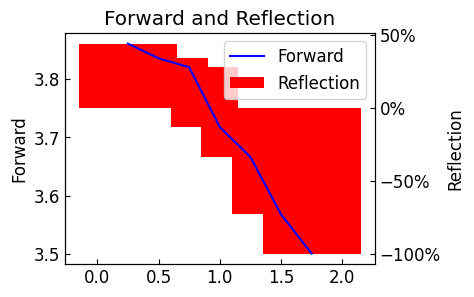

In [46]:
import matplotlib.ticker as mtick
# 0. 누락된 값을 제거
df = df.dropna(subset=['Forward', 'Reflection'])

# 1. 기본 스타일 설정
plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 12

# 2. 데이터 준비 index만 따로
x = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# 3. 그래프 그리기
fig, ax1 = plt.subplots()

# 4 선차트 그리기
ax1.plot(x, df['Forward'], color='blue', label='Forward')
ax1.set_ylabel('Forward')
ax1.tick_params(axis='both', direction='in')

# 5보조축으로 바차트 그리기
ax2 = ax1.twinx()
ax2.bar(x,df['Reflection']*100, color='red',label='Reflection')
ax2.set_ylabel('Reflection')
ax2.tick_params(axis='y', direction='in')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# 6범례 표시
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

ax1.set_zorder(ax2.get_zorder() + 10)
ax1.patch.set_visible(False)

# 7 그래프 출력
plt.title('Forward and Reflection')
plt.show()


In [47]:
df = df.drop(columns=['Spot','DF','Zero','Forward'])

styled_df = df.style.applymap(highlight_min_max)

# 스타일링된 데이터프레임 출력
styled_df

,Reflection
0.25,0.442123
0.50,0.341735
0.75,0.280573
1.00,-0.128999
1.25,-0.334594
1.50,-0.726867
1.75,-0.996170
